In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="S381X07ytsJBRFJec4Jr")
project = rf.workspace("robot-detgq").project("bonta-coil")
version = project.version(4)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bonta-coil-4 in coco:: 100%|██████████| 278/278 [00:00<00:00, 5909.99it/s]


In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [ ]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/bonta-coil-4/train",
    ann_file="/content/bonta-coil-4/train/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/bonta-coil-4/valid",
    ann_file="/content/bonta-coil-4/valid/_annotations.coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Initialize the model
num_classes = 3 # Background + chair, human, table
model = get_model(num_classes)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Process targets to ensure they are in the correct format and on the device
        processed_targets = []
        images_on_device = []
        for i, target_list in enumerate(targets): # targets is a list of lists of annotations
            boxes = []
            labels = []
            for annotation in target_list: # Each annotation is a dictionary
                # Extract bbox
                bbox = annotation["bbox"] # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive, and values are valid
                if w > 0 and h > 0 and all(isinstance(i, (int, float)) for i in [x, y, w, h]):
                   # Convert to [x_min, y_min, x_max, y_max] and append
                   boxes.append([x, y, x + w, y + h])
                   labels.append(annotation["category_id"])

            # Only create a target dictionary if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                images_on_device.append(images[i].to(device)) # Move image to device only if it has valid targets


        # Skip iteration if no valid targets were processed for the batch
        if not processed_targets:
            continue

        # Ensure images and targets are aligned and images are a batched tensor
        images = torch.stack(images_on_device) # Stack valid images into a single tensor
        targets = processed_targets

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

--------------------->

In [ ]:
train_one_epoch(model, optimizer, train_loader, device, 1)

Epoch [1] Loss: 0.2699


In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}")
    train_one_epoch(model, optimizer, train_loader, device ,  epoch)
    print("donne-------------->")
    lr_scheduler.step()
    print("donne-------------->")

Epoch 0/50
Epoch [0] Loss: 0.0541
donne-------------->
donne-------------->
Epoch 1/50
Epoch [1] Loss: 0.0458
donne-------------->
donne-------------->
Epoch 2/50
Epoch [2] Loss: 0.0638
donne-------------->
donne-------------->
Epoch 3/50
Epoch [3] Loss: 0.0380
donne-------------->
donne-------------->
Epoch 4/50
Epoch [4] Loss: 0.0547
donne-------------->
donne-------------->
Epoch 5/50
Epoch [5] Loss: 0.0571
donne-------------->
donne-------------->
Epoch 6/50
Epoch [6] Loss: 0.0610
donne-------------->
donne-------------->
Epoch 7/50
Epoch [7] Loss: 0.0542
donne-------------->
donne-------------->
Epoch 8/50
Epoch [8] Loss: 0.0550
donne-------------->
donne-------------->
Epoch 9/50
Epoch [9] Loss: 0.0543
donne-------------->
donne-------------->
Epoch 10/50
Epoch [10] Loss: 0.0652
donne-------------->
donne-------------->
Epoch 11/50
Epoch [11] Loss: 0.0696
donne-------------->
donne-------------->
Epoch 12/50
Epoch [12] Loss: 0.0531
donne-------------->
donne-------------->
Epoch 

---------------->

In [ ]:
# Set the model to evaluation mode
model.eval()
# Test on a new image
with torch.no_grad():
    for images, targets in val_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # The model expects a list of tensors as input
        predictions = model(images)

        # Example: print the bounding boxes and labels for the first image
        print(predictions[0]['boxes'])
        print(predictions[0]['labels'])

tensor([[452.0708, 120.4207, 562.1576, 298.4020],
        [182.0241,  65.7103, 464.6970, 450.4150]], device='cuda:0')
tensor([1, 2], device='cuda:0')
tensor([[413.8684, 157.7742, 533.5797, 354.6658],
        [155.3854, 117.6211, 423.2287, 442.2049],
        [639.9022, 523.2480, 640.0000, 538.7731],
        [639.9023, 523.1983, 640.0000, 538.7932]], device='cuda:0')
tensor([1, 2, 1, 2], device='cuda:0')
tensor([[412.3679, 261.0117, 533.6203, 456.4911],
        [150.3008, 211.8740, 427.3885, 536.7084]], device='cuda:0')
tensor([1, 2], device='cuda:0')
tensor([[388.0389, 278.4588, 508.2351, 475.5624],
        [117.8473, 209.9946, 412.3005, 551.0004]], device='cuda:0')
tensor([1, 2], device='cuda:0')


In [ ]:
    # Save the model's state dictionary after every epoch
model_path = f"fasterrcnn_resnet59_epoch_{epoch + 1}.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved: {model_path}")

Model saved: fasterrcnn_resnet59_epoch_50.pth


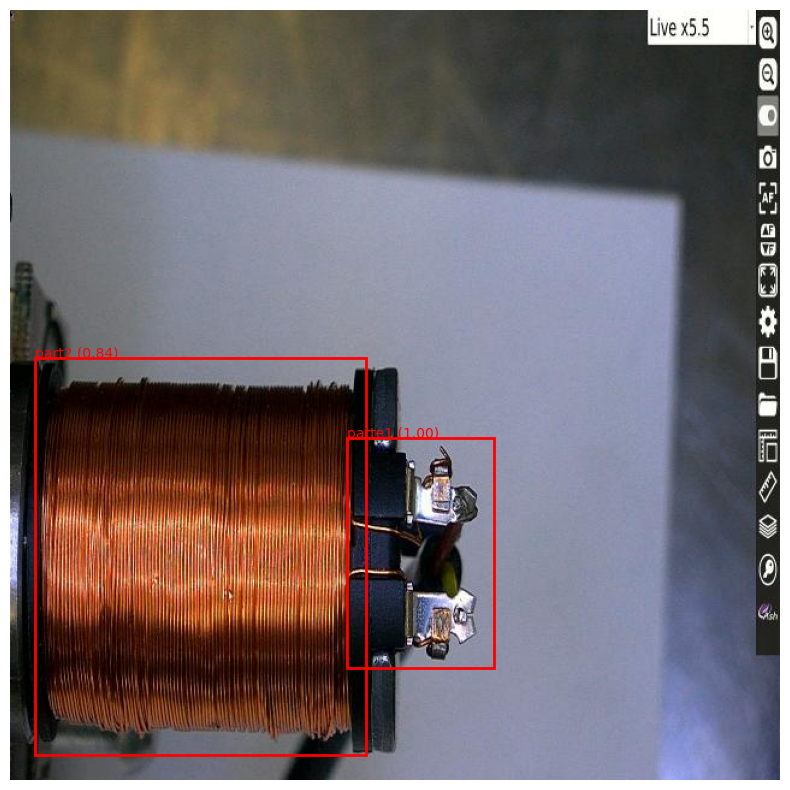

Runtime: 1.4388 seconds


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import time # Import the time module

# Start time
start_time = time.time()

image_path="/content/bonta-coil-4/test/WIN_20250528_16_51_00_Pro_jpg.rf.95769013872628ee9d0c4a8021ea297d.jpg"
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 3  # Background + chair + table (assuming 3 classes were used for training)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("fasterrcnn_resnet59_epoch_50.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "/content/bonta-coil-4/test/WIN_20250528_16_51_00_Pro_jpg.rf.95769013872628ee9d0c4a8021ea297d.jpg" # Use the correct image path
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "parte1", 2: "part2"} # Updated based on assumed 3 classes

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image_tensor, prediction, fig_size=(10, 10)): # Changed input parameter name to image_tensor
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5

    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    # Convert the image tensor back to a PIL Image for display
    image_pil = F.to_pil_image(image_tensor.squeeze(0).cpu()) # Use image_tensor here


    plt.imshow(image_pil)  # Display the image

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')

    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
# Pass the image_tensor to draw_boxes
draw_boxes(image_tensor, prediction, fig_size=(12, 10))  # Example of increased size

# End time
end_time = time.time()

# Calculate and print the runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.4f} seconds")